<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/v2.6_ML20M%20SUPERVISED%20CONTRASTIVE%20ONLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ver 6.0 
Supervised contrastive

In [1]:
!pip install tensorflow-addons
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Libs

In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import gc
import math
import datetime, time
from joblib import Parallel, delayed
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow_addons.losses import TripletSemiHardLoss 
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking

In [3]:
tf.__version__

'2.8.2'

In [4]:
itemCol = 'movieId'
userCol = 'userId'

In [5]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# Loading data
ratings = pd.read_csv(fpath+'/ratings.csv')

ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


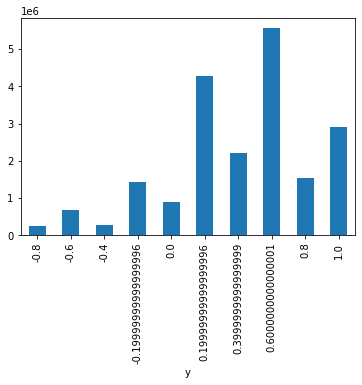

In [7]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

# Kiểm tra rating trong khoảng -1 -> 1
ratings.groupby("y")["y"].count().plot(kind='bar')

In [8]:
# Loading movie
movies = pd.read_csv(fpath+'/movies.csv')
movies["year"]=movies["title"].apply(lambda x: x[-5:-1])
movies["genres"] = movies["genres"].apply(lambda x: ' ' if x == '(no genres listed)' else ' '.join(x.split('|')) )
movies["title"]= movies["title"].apply(lambda x: x[0:-7])
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [9]:
# train-test split
fulltrain, test= train_test_split(ratings, test_size= 0.25)
train = fulltrain[fulltrain[userCol]<=50000]

In [10]:
top_k_item = 20000
wu_size = 200
max_item = wu_size

top_items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False).head(top_k_item).index

# Class  model

In [11]:
class TimeTrachker():
	"""Tracking runing time"""
	def start(self):
		self.start_time = time.time()

	def check(self, des = ''):
		try:
			if self.check_time is None:
				self.check_time = self.start_time
		except:
			self.check_time = self.start_time
		self.end_time = time.time()
		dur = self.end_time - self.check_time
		print(des + " duration: ", dur)

		self.check_time = time.time()
		return dur

	def stop(self, des = ''):
		self.end_time = time.time()
		dur = self.end_time - self.start_time
		print(des + " duration: ", dur)
		self.start_time = time.time()
		self.check_time = None
		return dur

timer = TimeTrachker()

In [12]:
def get_interaction_set(interaction, max_item = None, top_k_item = None):
    """
    Input:
        interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
        max_item: int: item num limit
    Output:
        df, itemCol: list, y: list, itemCol_str: string, userCol as index
        list item sắp xếp theo giảm dần độ lớn rating
    """
    items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
    if top_k_item is not None:
        top_items = items.head(top_k_item).index
        interaction = interaction[interaction[itemCol].isin(top_items)]
    else:
        top_items = items.index

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    interaction = interaction.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

    # Giới hạn độ dài warm_up size
    if max_item is not None:
        interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
        interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

    return interaction, top_items

In [13]:
# Bulding model
class Efficient_Rec(tf.keras.Model):
    def __init__(self, encoder, wu_size= 200, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.encoder = encoder
        self.wu_size = wu_size

    # from v2.2: chỉ groupby, không padding
    @staticmethod
    def get_interaction_set(interaction, max_item = None, top_k_item = None):
        """
        Input:
            interaction: df[userCol, itemCol, y]: dữ liệu đầu vào
            max_item: int: item num limit
        Output:
            df, itemCol: list, y: list, itemCol_str: string, userCol as index
            list item sắp xếp theo giảm dần độ lớn rating
        """
        items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False)
        if top_k_item is not None:
            top_items = items.head(top_k_item).index
            interaction = interaction[interaction[itemCol].isin(top_items)]
        else:
            top_items = items.index

        # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
        rindex = interaction.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
        interaction = interaction.reindex(rindex)
        
        # Chuyển thành warm-up set theo từng user
        interaction = interaction.groupby("userId").agg({itemCol:list, "y":list})

        # Giới hạn độ dài warm_up size
        if max_item is not None:
            interaction[itemCol] = interaction[itemCol].apply(lambda x: x[0:max_item])
            interaction["y"] = interaction["y"].apply(lambda x: x[0:max_item])

        return interaction, top_items

    def _preprocess(self, inputs, padding_size = 100):
        """
        Padding về wu_size và mask_size, convert list of items => string of items
        batch_inputs: df: itemStr, y"""

        def padding_list(list_item, wu_size, value=0, is_padding=True):
            series_item1 = list_item[0:wu_size]
            if is_padding:
                series_item1 = series_item1+[value]*(wu_size-len(series_item1))
            return series_item1

        items_list, ratings_list = inputs

        items   = items_list.apply(lambda x: ' '.join(list([str(i) for i in x])))
        ratings =   np.stack( ratings_list.apply(lambda x: padding_list( x, padding_size  ) ) )

        return items, ratings


    @staticmethod
    def get_top_cluster(scores, interaction_list):
        interaction_list_ = interaction_list.copy()
        idx = np.argsort(-scores.transpose(),axis=0)[:cluster_num]
        interaction_list_["clusters"] = [list(i) for i in idx.transpose()]
        interaction_list_["scores"] = [ list(scores[i][ind]) for i, ind in enumerate(idx.transpose()) ]
        return interaction_list_

    def minibatch_clustering(self, interaction_list, batch_size= 512):
        chunks = [interaction_list[i:i+batch_size] for i in range(0,interaction_list.shape[0],batch_size)]
        preds = []
        for chunk in chunks:
            pred = self.encoder(self._preprocess( [chunk[itemCol], chunk["y"]], padding_size = wu_size )).numpy()
            preds.append( pred )

        return np.concatenate(preds)

    @staticmethod
    def chunk_explode(ratings, batch_size = 1024**2):
        chunks = [ratings[i:i+batch_size] for i in range(0,ratings.shape[0],batch_size)]
        explodes = []

        # Todo: convert for loop to parallel
        def chunk_process(chunk):
            explode = chunk.explode(["clusters", "scores"])
            explode["contribute_score"] = explode["scores"].astype("float64")*explode["y"]
            explode = explode.groupby(["clusters", "movieId"]).agg({
                "contribute_score": ["mean", "count"]
            }).reset_index()
            explode.columns = ["clusters", "movieId", "mean", "count"]

            return explode

        explodes = Parallel(n_jobs = -1, verbose = 1)(
                    delayed(chunk_process)(chunk) for chunk in tqdm(chunks))
        # combine results
        gr = pd.concat(explodes, axis = 0)
        gr["product"] = gr["mean"]*gr["count"]
        gr = gr.groupby(["clusters", "movieId"]).sum().reset_index()
        gr["contribute_score"] = gr["product"]/gr["count"]
        gr = gr[["clusters", "movieId", "contribute_score"]]
        return gr

    def get_shortlist(self, ratings, interaction_list= None, limit = 500, cluster_num = 5, batch_size=512):
        timer.start()
        if interaction_list is None:
            interaction_list_, _ = self.get_interaction_set(  ratings, max_item = max_item, top_k_item = top_k_item  )
        else:
            interaction_list_ = interaction_list.copy()

        scores = self.minibatch_clustering(interaction_list_, batch_size=batch_size)

        # Limit number of cluster for each user
        interaction_list_ = self.get_top_cluster(scores, interaction_list_)
        timer.check(des = "Get cluster")

        # Get shortlist for each cluster
        ratings_ = ratings.copy().set_index("userId")
        ratings_ = ratings_[ratings_["y"]>0]
        ratings_ = ratings_.join(interaction_list_, rsuffix="_l", how = "inner")
        timer.check(des = "Join interaction")
        ratings_ = self.chunk_explode(ratings_, batch_size= 1024*200)
        timer.check(des = "Chunk explode")

        ratings_["rank"] = ratings_.groupby("clusters")["contribute_score"].rank(method='first', ascending=False)
        ratings_ = ratings_[(ratings_["rank"] <= limit)&(ratings_["contribute_score"]>0)]
        timer.check(des = "Chunk explode")

        self.shortlist = ratings_

        timer.stop(des = "Total")

    @staticmethod
    def left_anti_user_item_join( left, right ):
        """Fast left anijoin 2 dataframe by one column"""
        wu_key = left[userCol].astype('str')+"&"+left[itemCol].astype('str')
        blacklist = right[userCol].astype('str')+"&"+right[itemCol].astype('str')

        key_diff = set(wu_key).difference(blacklist)
        where_diff = wu_key.isin(key_diff)
        output = left[where_diff]

        return output


    def batch_get_recommend(self, warm_up= None, historical_ratings = None, top_k = 10, is_remove_interacted = True, batch_size=1024):
        timer.start()
        if warm_up is None:
            warm_up, _ = self.get_interaction_set( 
                         historical_ratings
                        , max_item = max_item
                        , top_k_item = top_k_item )

        scores = self.minibatch_clustering(warm_up, batch_size=512)
        wu = self.get_top_cluster( scores, warm_up)

        wu = wu.explode(["clusters", "scores"]).reset_index()[[userCol, "clusters", "scores"]]
        timer.check(des = "Get cluster for user")
        
        user_num = wu[userCol].drop_duplicates().shape[0]

        chunks = [wu[wu[userCol].isin(range(i,i+batch_size))] 
                  for i in range(0,user_num,batch_size)]

        his_chunks = [historical_ratings[historical_ratings[userCol].isin(range(i,i+batch_size))] 
                        for i in range(0,user_num,batch_size)]
       
        shortlist = self.shortlist

        def batch_join_process(chunk, his_chunk):
            wu = chunk.merge(shortlist, on="clusters", how='inner')
            wu["matched_score"] = wu["scores"]*wu["contribute_score"]
            wu = wu.groupby([userCol, itemCol]).agg({"matched_score":'mean'}).reset_index()
            # using drop_duplicates for boost speed, may reduce accuracy.
            # wu = wu.drop_duplicates(subset=["userId", "movieId"])

            if is_remove_interacted:
                wu = self.left_anti_user_item_join( wu, historical_ratings )

            wu["rank"] = wu.groupby(userCol)["matched_score"].rank(method='first', ascending=False)
            wu = wu[wu["rank"]<= top_k]

            return wu 
        
        timer.check(des = "Prepare to join")
        wus = Parallel(n_jobs = -1, backend= 'threading', verbose = 1)(
                    delayed(batch_join_process)(chunk, his_chunk) for chunk, his_chunk in tqdm(zip(chunks, his_chunks)))
        
        gc.collect()

        timer.check(des = "Join")

        output = pd.concat(wus, axis=0)

        timer.stop(des = "Total")
        return output

    def release_cache(self):
        self.interaction_list = None 
        gc.collect()

# Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [14]:
%%time
# Vectorize (encode + padding) item list
max_vocab_size = len(top_items) # nếu số item có <= top_k_item => lấy số lượng item max
items_str = ' '.join([str(i) for i in top_items])
itemStr = itemCol+"_str"

vectorizer = layers.TextVectorization( max_tokens= top_k_item, split='whitespace', output_sequence_length= wu_size, name = 'vectorizer')
vectorizer.adapt( [items_str] ) 

CPU times: user 375 ms, sys: 47.4 ms, total: 422 ms
Wall time: 959 ms


In [15]:
class Broadcasting_Multiply(tf.keras.layers.Layer):
    """Nhân 2 layers khác shape với nhau, trong đó:
    inputs=[layer1, layer2]
    layer1.shape = (None, n_item, n_feature)
    layer2.shape = (None, n_item)
    (Chú ý đúng thứ tự)
    """

    def call(self, inputs):
        x, y = inputs
        deno = tf.expand_dims(tf.cast(tf.math.count_nonzero(y, axis=1), tf.float32), -1)
        #we add the extra dimension:
        y = K.expand_dims(y, axis=-1)
        #we replicate the elements
        y = K.repeat_elements(y, rep=x.shape[2], axis=-1)

        return x * y, deno

In [16]:
# Xây dựng mạng
embedding_size = 173
reps_size = 132
cluster_num = 43

@tf.function
def avg_layer(z):
    t = K.sum(z[0], axis=1)/z[1]
    t = tf.clip_by_value( t, -1, 1 )
    t = tf.where(tf.math.is_nan(t), tf.zeros_like(t), t)
    return t


def interaction_embedding():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di1')(wi)
    wi = layers.Dense(embedding_size, activation='relu', use_bias = False, name='di2')(wi)
    # wi = layers.Dense(embedding_size, activation='sigmoid', use_bias = False, name='di3')(wi)

    wr = layers.Input(shape=(wu_size,), name='warm_up_ratings')

    ireps = Broadcasting_Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)

    uprofile = layers.Dense( reps_size, activation='relu', name='du1')(uprofile)
    uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du3')(uprofile)
    # uprofile = layers.BatchNormalization(name='norm')(uprofile)
    uprofile = layers.LayerNormalization(name='norm')(uprofile)
    # uprofile = layers.Dense( reps_size, activation='relu', name='du4')(uprofile)
    uprofile = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(uprofile)
    
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[uprofile])
    return model

In [17]:
# # Example of layer interaction embedding step by step
# input_wi = ["15 25 65 20 84",  # 5 items
#             "51 54 45 21 24 83 81 76 74 75 72 48 29 38",# 14 items
#             " ",] 

# tvectorizer = layers.TextVectorization( max_tokens= 17, split='whitespace', output_sequence_length= 10)
# tvectorizer.adapt( input_wi ) 

# wi = tvectorizer(input_wi)
# print(wi)
# wi = layers.Embedding(input_dim= 17, output_dim= 4, mask_zero= True, name='ei')(wi)
# print(wi)
# wi = layers.Dense(3, activation='sigmoid',  use_bias = False, name='di')(wi)

# wr = np.array([[0.5, 0.1, -0.5, 1, 0.25, 0, 0, 0, 0, 0], [0.25, 0.15, 0.5, 1, 0.25, 0.5, 0.1, -0.9, 0.4, -0.3], [0,0,0,0,0,0,0,0,0,0]])

# ireps = Broadcasting_Multiply(name='mul')([wi, wr])
# print(ireps)
# uprofile = layers.Lambda(lambda z: avg_layer(z) )(ireps)
# print(uprofile)

# uprofile = layers.Dense( reps_size, activation='relu', name='du2')(uprofile)
# uprofile = layers.LayerNormalization(name='norm')(uprofile)
# uprofile = layers.Dense(5, activation='sigmoid', name='clustering')(uprofile)
# print(uprofile)

In [18]:
# Kiểm tra tham số
# interaction_embedding().summary()

In [19]:
# tf.keras.utils.plot_model( interaction_embedding() ,show_shapes=True, show_dtype=True, show_layer_names=True )

# Evaluate model results

In [20]:
def model_evaluate(model, movies, df):
    dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()

    print("SAMPLE INTERACTION EMBEDDING")
    print( np.max(group_scores), np.mean(group_scores), np.min(group_scores) )
    print( group_scores[0:3] )

    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    
    print("CLUSTER CHECKING")
    check_cluster(group_scores)
    
    print("SPECTROGRAM PLOT")
    plot_spectrogram(group_scores)

def get_label(movies, df, is_encode = False):
    movies["genres_list"] = movies["genres"].apply(lambda x: x.split(' '))
    movie_genres = movies.explode("genres_list")
    gr = df.merge(movie_genres, on="movieId").groupby(["userId", "genres_list"])["movieId"].count().reset_index()
    gr["rank"] = gr.groupby("userId")["movieId"].rank(method='first', ascending=False)

    labels = gr[gr["rank"] ==1].set_index("userId")
    # labels["pred_max_ind"] = np.argmax(group_scores, axis=1)

    if is_encode:
        label_enc = LabelEncoder()
        labels["label"] = label_enc.fit_transform(labels["genres_list"])

    return labels

def feature_plot( movies, df, group_scores ):
    tlabels = get_label(movies, df)

    tsne = PCA(n_components=2, random_state=123)
    # tsne = TSNE(n_components=2, random_state=123)
    z = tsne.fit_transform(group_scores) 

    df = pd.DataFrame()
    df["y"] = tlabels["genres_list"]
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    plt.rcParams["figure.figsize"] = (8,8)
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette="Paired" ,#sns.color_palette("hls", 3),
                    data=df)#.set(title="Iris data T-SNE projection") 
    plt.show()

def check_cluster(group_scores):
    # Kiểm tra số user trong mỗi cụm có bị vón cục
    ugs= np.argmax(group_scores, axis=1)
    for i in range(50):
        print(i,': ', np.sum(ugs==i) )

def plot_spectrogram(group_scores):
    # Sort theo user_group + draw sigmoid/softmax layer
    plt.rcParams["figure.figsize"] = (10,10)
    k =100
    a = group_scores
    ind = np.argmax(group_scores, axis=1)
    plt.imshow( a[np.argsort(ind)][0:k] )
    plt.show()


In [21]:
def model_plot(model, movies, df):
    dfu, ttop_items = get_interaction_set( df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    group_scores = model.encoder(model._preprocess( [dfu[itemCol], dfu["y"]], padding_size = wu_size )).numpy()
    print("FEATURE PLOT")
    feature_plot( movies, df, group_scores)
    

# Warm start user

In [22]:
%%time
u_train_from = 0
u_train_to = u_train_from + 100000
u_test = u_train_to + 5000

def get_labeled_data(df):
    interact_df, _ = get_interaction_set( 
                     df
                    , max_item = max_item
                    , top_k_item = top_k_item )
    labels = get_label( movies, df, is_encode = True)
    interact_df["label"] = labels["label"]
    return interact_df[["movieId","y","label"]]
try:
    train_warm
except:
    # if exists, do not rerun
    train_warm =  get_labeled_data( train[(train[userCol]>u_train_from)&(train[userCol]<u_train_to)] )
    train_warm["rating_num"] = train_warm.apply(lambda x: len(x["y"]), axis=1)
    # pretrain with warm start user
    train_warm = train_warm[train_warm["rating_num"]>=100]

train_warm.count()

CPU times: user 36.7 s, sys: 1.11 s, total: 37.8 s
Wall time: 40.6 s


In [23]:
gc.collect()

50

# supervised constrastive 

In [24]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [25]:
# Thực hiện training
def _supervised_constrastive_train_step(self, inputs):
    items_pd, ratings_pd, labels = inputs["movieId"], inputs["y"], inputs["label"]
    items, ratings = self._preprocess((items_pd, ratings_pd), wu_size)

    with tf.GradientTape() as tape:
        # Interaction embedding
        vec = self.encoder([items, ratings])

        average_loss = self.loss(labels, vec)

    # Apply an optimization step
    variables = self.trainable_variables 
    gradients = tape.gradient(average_loss, variables)
    
    # Gradient clipping
    # gradients = [None if gradient is None else tf.clip_by_value(gradient, -0.1, 0.1)
    #              for gradient in gradients]
    self.optimizer.apply_gradients(zip(gradients, variables))

    # Return a dict mapping metric names to current value
    return {'batch_loss': average_loss}

Efficient_Rec._supervised_constrastive_train_step = _supervised_constrastive_train_step

In [26]:
# Thực hiện minibatch training
def _spv_constrastive_train_minibatch_step(self, inputs, batch_size):
    df = inputs.copy()
    chunks = [df[i:i+batch_size] for i in range(0,df.shape[0],batch_size)]
    losses = []
    for chunk in chunks:
        loss = self._supervised_constrastive_train_step(chunk)
        losses.append(loss["batch_loss"].numpy())
        print(loss)
        gc.collect()
    return np.mean(losses)

Efficient_Rec._spv_constrastive_train_minibatch_step = _spv_constrastive_train_minibatch_step

In [27]:
# Compile model
model = Efficient_Rec( encoder = interaction_embedding(), 
                      wu_size = wu_size,
                      use_tf_function=False)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate = 0.001),
    loss= TripletSemiHardLoss() # SupervisedContrastiveLoss(temperature = 0.05),
)

In [ ]:
%%time
epochs= 1
test_set = train[(train[userCol]>10000)&(train[userCol]<12500)]
model_plot(model, movies, test_set )
for n in range(epochs):
  print(n, "/", epochs, ": ", model._spv_constrastive_train_minibatch_step(train_warm.sample(frac=0.1), batch_size=512))
  model_plot(model, movies, test_set )
  gc.collect()

In [29]:
# model_evaluate(model, movies, 
#                warm_up_mask[(warm_up_mask[userCol]>u_train_to)&(warm_up_mask[userCol]<(u_train_to+5000))])

# Pick item pipeline

In [30]:
%%time 
# START
# model.get_shortlist( train, limit = 500, cluster_num = 5)

# Pick shortlist base on warm start user only
# Large cluster num, small limit top item
model.get_shortlist( 
    ratings = train[train[userCol].isin(train_warm.index)],
    interaction_list = train_warm,
    limit = 250, 
    cluster_num = 10
)


Get cluster duration:  13.723836898803711
Join interaction duration:  1.6583943367004395


100%|██████████| 16/16 [01:16<00:00,  4.79s/it]
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.4min finished


Chunk explode duration:  88.93765306472778
Chunk explode duration:  0.3143754005432129
Total duration:  104.64068818092346
CPU times: user 36.1 s, sys: 1.86 s, total: 37.9 s
Wall time: 1min 44s


In [32]:
gc.collect()

883

In [33]:
model.shortlist

,clusters,movieId,contribute_score,rank
131,0,133,0.370206,216.0
645,0,654,0.473113,8.0
1789,0,1886,0.406085,123.0
3205,0,3332,0.452225,21.0
4308,0,4461,0.524967,1.0
...,...,...,...,...
810541,42,129241,0.577367,100.0
810552,42,129478,0.590274,43.0
810582,42,130588,0.472879,247.0
810583,42,130644,0.565393,136.0


In [34]:
%%time 
# interaction_list = train_warm[train_warm.index<=3000]
top_k = 50
is_remove_interacted = True

y_pred = model.batch_get_recommend( 
        warm_up = train_warm, 
        historical_ratings= train, 
        top_k = top_k, is_remove_interacted = False, batch_size=1024*4
    )

Get cluster for user duration:  14.091463804244995
Prepare to join duration:  0.595372200012207


0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
4it [04:46, 71.74s/it]
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 10.3min finished


Join duration:  619.9017286300659
Total duration:  634.5999631881714
CPU times: user 11min 20s, sys: 47.6 s, total: 12min 8s
Wall time: 10min 34s


In [44]:
train_warm

,movieId,y,label,rating_num
userId,,,,
1,"[4993, 7153, 8507, 1198, 8636, 1219, 7757, 633...","[1.0, 1.0, 1.0, 0.8, 0.8, 0.6000000000000001, ...",1,131
3,"[593, 1909, 1129, 924, 2118, 2985, 2009, 457, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15,136
7,"[480, 3417, 1196, 912, 1077, 4963, 4799, 589, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4,199
11,"[60684, 2291, 1580, 1748, 8973, 880, 4370, 334...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,200
14,"[17, 2394, 529, 6424, 150, 6297, 45431, 52287,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4,181
...,...,...,...,...
49974,"[260, 296, 733, 610, 1279, 2571, 1517, 188, 21...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16,139
49989,"[1073, 1214, 1206, 1198, 919, 1265, 1240, 1784...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4,200
49990,"[1645, 750, 1282, 44191, 3578, 4027, 110, 5087...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.8, ...",7,200


In [35]:
y_pred["rating"] = y_pred["matched_score"].astype("float")*2.5+2.5

In [36]:
y_pred

,userId,movieId,matched_score,rank,rating
5,1,3279,0.258225,38.0,3.145561
7,1,3607,0.256940,41.0,3.142351
9,1,4449,0.264156,14.0,3.160390
13,1,5744,0.272724,4.0,3.181809
14,1,5934,0.263988,15.0,3.159969
...,...,...,...,...,...
521687,16383,117551,0.275739,13.0,3.189348
521700,16383,122092,0.283905,4.0,3.209763
521704,16383,125786,0.269639,27.0,3.174097
521715,16383,127879,0.282984,8.0,3.207460


In [37]:
y_true = test[test["y"]>0]

In [38]:
y_pred.dtypes

userId             int64
movieId            int64
matched_score    float64
rank             float64
rating           float64
dtype: object

In [39]:
%%time
eval_map = map_at_k(y_true, y_pred, col_user = userCol, col_item = itemCol ,col_prediction='rating', col_rating="rating", k=top_k)
eval_ndcg = ndcg_at_k(y_true, y_pred, col_user = userCol, col_item = itemCol ,col_prediction='rating', col_rating="rating", k=top_k)
eval_precision = precision_at_k(y_true, y_pred, col_user = userCol, col_item = itemCol ,col_prediction='rating', col_rating="rating", k=top_k)
eval_recall = recall_at_k(y_true, y_pred, col_user = userCol, col_item = itemCol, col_prediction='rating', col_rating="rating", k=top_k)

print('K = %f' % top_k)
print(
    "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

K = 50.000000
MAP:	0.000001
NDCG:	0.000032
Precision@K:	0.000029
Recall@K:	0.000011
CPU times: user 44.4 s, sys: 634 ms, total: 45 s
Wall time: 44.8 s


In [48]:
y_true2 = test
y_true2["is_fav"] = y_true2["rating"].apply(lambda x: 1 if x>2.5 else 0)

In [53]:
y_pred2 = y_pred
y_pred2["is_rec"] = 1

In [73]:
def evaluate_rs2(y_true, y_pred):
    """
    y_true: dataframe: user_id, item_id, is_fav (1 true, 0 false)
    y_pred: dataframe: user_id, item_id
    return:
    precision@k, recall@k
    """
    y_pred2 = y_pred.copy()
    y_pred2["is_rec"] = 1

    y_true2 = y_true.copy()

    total1 = y_true2.merge(y_pred2, on=[userCol, itemCol], how = 'left')

    total1["rec_fav"] = total1["is_rec"].fillna(0) * total1["is_fav"]

    # Precision
    p = total1["rec_fav"].sum() / total1["is_rec"].sum()

    # Recall
    r = total1["rec_fav"].sum() / total1["is_fav"].sum()

    # print("Precision : ", p)
    # print("Recall : ", r)
    return p, r

In [77]:
precision, recall = evaluate_rs2(y_true2, y_pred)

In [78]:
print("Precision :", precision)

Precision : 0.5384615384615384


# END HERE

In [ ]:
1/0

In [40]:
def evaluate_rs(y_true, y_pred, is_return_df = False):
    """
    y_true: dataframe: user_id, item_id, y (rating normailised), only favorite item
    y_pred: dataframe: user_id, item_id (just top k item)
    return:
    precision@k, recall@k
    """
    total1 = y_true.merge(y_pred, on=[userCol, itemCol], how = 'outer', suffixes=('_t', '_p'))
    total1['is_pt'] = total1.apply(lambda x: 0 if (np.isnan(x["y"]) or np.isnan(x["rank"]) ) else 1,axis=1)
    total = total1.groupby(userCol).agg({
        "y":'count',
        "rank":'count',
        "is_pt": 'sum'
        })
    total.columns = ["true_num", "predict_num", "pred_true_num"]
    total["macro_p"] = total["pred_true_num"]/total["predict_num"]
    total["macro_r"] = total["pred_true_num"]/total["true_num"]

    total = total[total["predict_num"]>0]

    macro_p = total[total["predict_num"]>0]["macro_p"].mean()
    macro_r = total[total["true_num"]>0]["macro_r"].mean()

    micro_p = total["pred_true_num"].sum()/total["predict_num"].sum()
    micro_r = total["pred_true_num"].sum()/total["true_num"].sum()

    print("macro_p: ", macro_p, "; macro_r :", macro_r)
    print("micro_p: ", micro_p, "; micro_r :", micro_r)

    if is_return_df:
        return (macro_p, macro_r, micro_p, micro_r), total

    return macro_p, macro_r, micro_p, micro_r

In [41]:
%%time
eval_metrics, eval_df = evaluate_rs(y_true, y_pred, is_return_df= True)

macro_p:  2.8694404591104736e-05 ; macro_r : 1.0985551732393168e-05
micro_p:  2.8694404591104736e-05 ; micro_r : 1.9419091741337697e-05
CPU times: user 1min 37s, sys: 36.1 ms, total: 1min 37s
Wall time: 1min 37s


In [42]:
eval_df[eval_df['pred_true_num']>0]

,true_num,predict_num,pred_true_num,macro_p,macro_r
userId,,,,,
3625,313,50,1,0.02,0.003195
8083,154,50,1,0.02,0.006494
8213,107,50,1,0.02,0.009346
9034,439,50,1,0.02,0.002278
9797,163,50,1,0.02,0.006135
10575,42,50,1,0.02,0.023810
12131,427,50,1,0.02,0.002342


In [43]:
%%time
macro_p, macro_r, micro_p, micro_r= evaluate_rs(y_true, y_pred)

macro_p:  2.8694404591104736e-05 ; macro_r : 1.0985551732393168e-05
micro_p:  2.8694404591104736e-05 ; micro_r : 1.9419091741337697e-05
CPU times: user 1min 39s, sys: 0 ns, total: 1min 39s
Wall time: 1min 40s
